In [1]:
import pickle
import os
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib
from matplotlib import pyplot as plt
import sys
sys.path.insert(0, '../modeling/')
from create_ASM_batch import *

matplotlib.rcParams['figure.figsize'] = [13, 10]

# Create and import data

In [2]:
if os.path.exists("../modeling/tf_output/online_data/modified_data.csv"):
    redata = pd.read_csv("../modeling/tf_output/online_data/modified_data.csv")
else:
    # Load in data
    # training csv with image locations and transcriptions
    data = pd.read_pickle("../modeling/tf_output/online_data/online_metrics59000.pkl")
    pred_data = data[data.pred == "pred"]

    # Get pertinent information from only prediction data
    redata = pd.DataFrame(columns=["filename", "label", "word", "subject_id", "class_id", "frame", "line_num", "bunch"])
    for i in range(len(pred_data)):
        curdat = pred_data.iloc[i]
        labels = [str(d, "utf-8") for d in curdat["labels"][0]]
        words = [str(d, "utf-8") for d in curdat["words"][0]]
        filenames = [str(d, "utf-8") for d in curdat["filenames"][0]]

        fns = [f.split("/")[-1].replace(".png", "") for f in filenames]
        ids = [[str(int(float(idd))) for idd in f.split("_")] for f in fns]
        subject_id = [f[0] for f in ids]
        class_id = [f[1] for f in ids]
        frame = [f[2] for f in ids]
        line_num = [f[3] for f in ids]
        bunch_num = [curdat["bunch"] for j in range(len(fns))]

        data_dict = {"filename":filenames, "label":labels, "word":words, 
                     "subject_id":subject_id, "class_id":class_id, "frame":frame,
                     "line_num":line_num, "bunch":bunch_num}
        newdata = pd.DataFrame.from_dict(data_dict, dtype="str")
        redata = redata.append(newdata)

        if i % 100 == 0: print(i, end="\t")

    # Figure out which data has been seen before based on subject id
    subj_set = set()
    seen_before = []

    for i in range(len(redata)):
        combo = redata.iloc[i]["subject_id"] + "_" + redata.iloc[i]["frame"] + "_" + redata.iloc[i]["line_num"]
        if combo in subj_set:
            seen_before.append(True)
        else:
            seen_before.append(False)
            subj_set.add(combo)

    redata["unseen_subj"] = np.logical_not(seen_before)

    # get character error rate
    def cer(r, h):
        r = list(r)
        h = list(h)
        # initialisation
        import numpy
        d = numpy.zeros((len(r)+1)*(len(h)+1), dtype=numpy.uint8)
        d = d.reshape((len(r)+1, len(h)+1))
        for i in range(len(r)+1):
            for j in range(len(h)+1):
                if i == 0:
                    d[0][j] = j
                elif j == 0:
                    d[i][0] = i

        # computation
        for i in range(1, len(r)+1):
            for j in range(1, len(h)+1):
                if r[i-1] == h[j-1]:
                    d[i][j] = d[i-1][j-1]
                else:
                    substitution = d[i-1][j-1] + 1
                    insertion    = d[i][j-1] + 1
                    deletion     = d[i-1][j] + 1
                    d[i][j] = min(substitution, insertion, deletion)

        return d[len(r)][len(h)]/len(r)

    count = 0
    onepercent = len(redata)//100
    tenpercent = onepercent*10

    cers = []
    for i in range(len(redata)):
        cers.append(cer(redata.iloc[i]["label"], redata.iloc[i]["word"]))

        count += 1
        if count % onepercent == 0:
            if count % tenpercent == 0:
                perc = count//onepercent
                print(str(perc)+"%", end="", flush=True)
            else:
                print(".", end="", flush=True)

    redata["cer"] = cers

    redata.to_csv("../modeling/tf_output/online_data/modified_data.csv", index=False)

# Resulting transcriptions

In [3]:
# Choose which training group to look at
bunch = 59000
# Create the dataset for that batch
create_ASM_batch(bunch, 1000, data_loc="../data")

Loading classification data
Creating image files and training csv
.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100%
Training file and 1000 images created


In [4]:
newstuff = redata[np.logical_and(redata.bunch == bunch, redata.unseen_subj)]
# remove "[insertion] tags
has_insert = ["[insertion]" in newstuff.iloc[i]["label"] 
              for i in range(len(newstuff))]
newstuff = newstuff[np.logical_not(has_insert)]
print(len(newstuff))

184


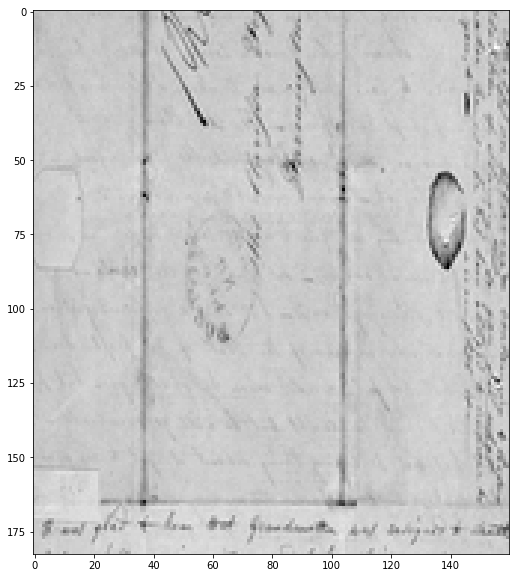

Prediction:       ?
Label: I was glad to hear that grandmother was resigned to death -
Filename: C:/Users/danny/Repos/text_recognition/data/ASM/Images/13890972_87686299_3_4.png
CER: 0.8983050847457628
-----------------------------------------------------------------------------


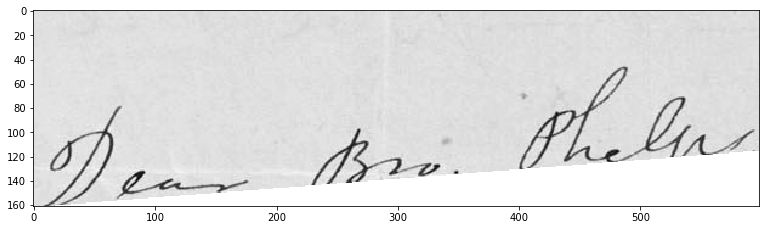

Prediction:      
Label: Dear Bro. Phelps,
Filename: C:/Users/danny/Repos/text_recognition/data/ASM/Images/13895092_87684002_0_0.png
CER: 0.8823529411764706
-----------------------------------------------------------------------------


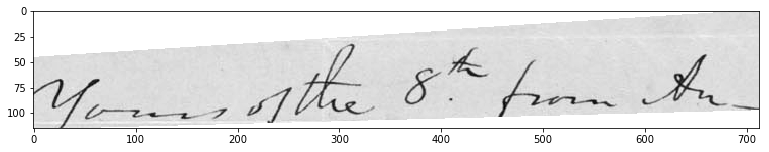

Prediction:     
Label: Yo?? of the 8th from Andover
Filename: C:/Users/danny/Repos/text_recognition/data/ASM/Images/13895092_87684002_0_1.png
CER: 0.8571428571428571
-----------------------------------------------------------------------------


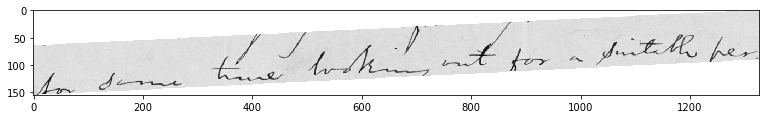

Prediction:   e          
Label: for some time looking out for a suitable person
Filename: C:/Users/danny/Repos/text_recognition/data/ASM/Images/13895092_87684002_0_3.png
CER: 0.8085106382978723
-----------------------------------------------------------------------------


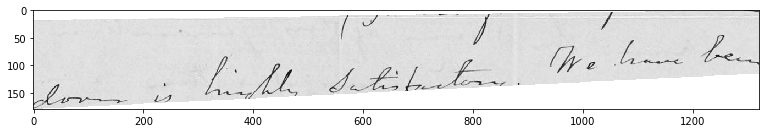

Prediction: o  i  b   i  to      
Label: is highly satisfactory. We have been
Filename: C:/Users/danny/Repos/text_recognition/data/ASM/Images/13895092_87684002_0_2.png
CER: 0.75
-----------------------------------------------------------------------------


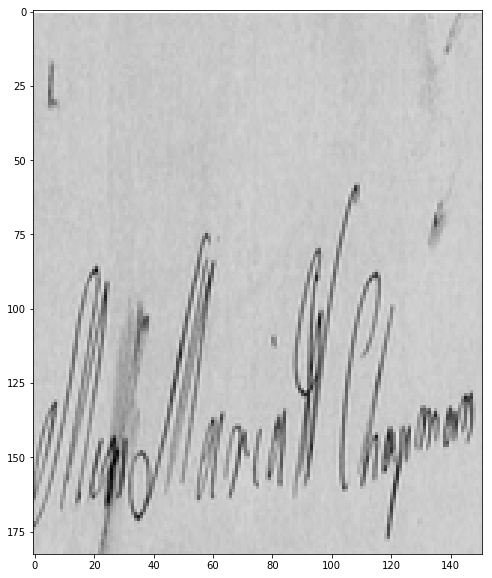

Prediction: MaMriat Romoar
Label: Mrs Marion W Chapman
Filename: C:/Users/danny/Repos/text_recognition/data/ASM/Images/13896504_87673049_3_0.png
CER: 0.7
-----------------------------------------------------------------------------


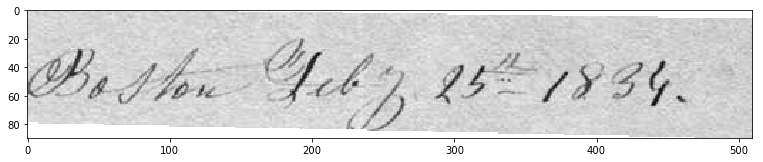

Prediction: Dostor fibf hs 18834.
Label: Boston Feby 25th 1834.
Filename: C:/Users/danny/Repos/text_recognition/data/ASM/Images/13890972_87686299_0_0.png
CER: 0.4545454545454545
-----------------------------------------------------------------------------


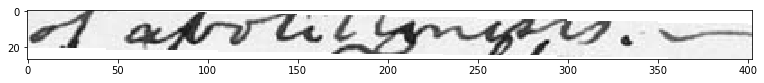

Prediction: of aboiness.
Label: of abolitionists. -
Filename: C:/Users/danny/Repos/text_recognition/data/ASM/Images/13897285_87676499_1_8.png
CER: 0.42105263157894735
-----------------------------------------------------------------------------


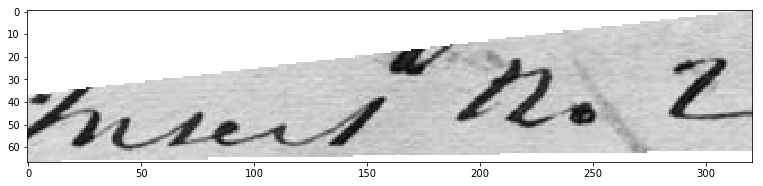

Prediction: nsers Me 2
Label: Insert No 2.
Filename: C:/Users/danny/Repos/text_recognition/data/ASM/Images/13885705_87687035_1_18.png
CER: 0.4166666666666667
-----------------------------------------------------------------------------


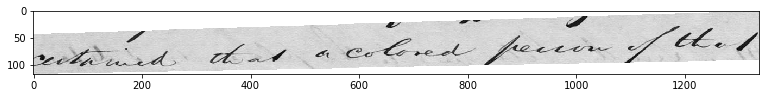

Prediction: ceituined thas a colored person of thas
Label: that a colored person of that
Filename: C:/Users/danny/Repos/text_recognition/data/ASM/Images/13885705_87687035_1_5.png
CER: 0.4137931034482759
-----------------------------------------------------------------------------


In [5]:
strt = 0
stop = 10
newstuff = newstuff.sort_values("cer", ascending=False)
for i in range(strt, stop):
    lab = newstuff.iloc[i]["label"]
    wor = newstuff.iloc[i]["word"]
    cer = newstuff.iloc[i]["cer"]
    img = newstuff.iloc[i]["filename"]
    img = img.replace("/home/hans3724", "C:/Users/danny/Repos")
    img = img.replace(".0", "")
    try:
        plt.imshow(np.asarray(Image.open(img)), cmap="gray")
        plt.show()
    except:
        pass
    print("Prediction: {0}\nLabel: {1}\nFilename: {2}\nCER: {3}".format(wor, lab, img, cer))
    print("-----------------------------------------------------------------------------")

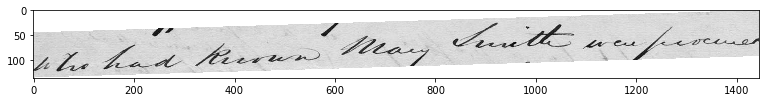

Prediction: wntrs had krroun Mary Mrithe wereprocuce
Label: who had known Mary Smith were procured
Filename: C:/Users/danny/Repos/text_recognition/data/ASM/Images/13885705_87687035_1_9.png
CER: 0.34210526315789475
-----------------------------------------------------------------------------


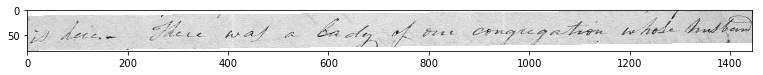

Prediction: is dac. - Here was a ady of or congrugation whase Mustad
Label: is here. - There was a Lady of one congregation whose husband
Filename: C:/Users/danny/Repos/text_recognition/data/ASM/Images/13890972_87686299_0_22.png
CER: 0.2295081967213115
-----------------------------------------------------------------------------


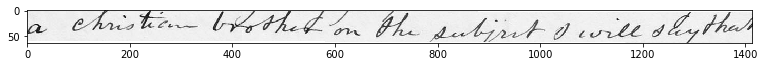

Prediction: a christian btoshet on the subjrrt I will sey tha
Label: a christian brother on the subject I will say that
Filename: C:/Users/danny/Repos/text_recognition/data/ASM/Images/13897285_87676499_1_3.png
CER: 0.14
-----------------------------------------------------------------------------


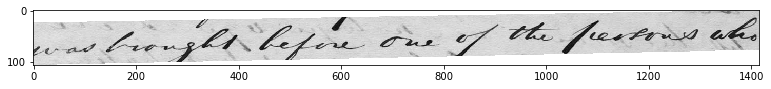

Prediction: was brought before one of the pessons who
Label: was brought before one of the persons who
Filename: C:/Users/danny/Repos/text_recognition/data/ASM/Images/13885705_87687035_2_2.png
CER: 0.024390243902439025
-----------------------------------------------------------------------------


In [6]:
# display stuff for the poster
want_it  = ["was brought before one of the pessons who",
            "a christian btoshet on the subjrrt I will sey tha",
            "is dac. - Here was a ady of or congrugation whase Mustad",
            "wntrs had krroun Mary Mrithe wereprocuce"]

for i in range(len(newstuff)):
    if newstuff.iloc[i]["word"] in want_it:
        lab = newstuff.iloc[i]["label"]
        wor = newstuff.iloc[i]["word"]
        cer = newstuff.iloc[i]["cer"]
        img = newstuff.iloc[i]["filename"]
        img = img.replace("/home/hans3724", "C:/Users/danny/Repos")
        img = img.replace(".0", "")
        try:
            plt.imshow(np.asarray(Image.open(img)), cmap="gray")
            plt.show()
        except:
            pass
        print("Prediction: {0}\nLabel: {1}\nFilename: {2}\nCER: {3}".format(wor, lab, img, cer))
        print("-----------------------------------------------------------------------------")